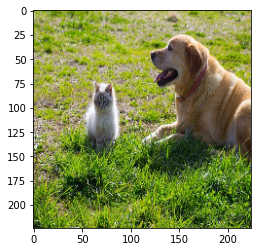

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pylab as plt

img = cv2.imread('aa.jpg')
img = cv2.resize(img, (224, 224))
rgb_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(rgb_img)

In [2]:
# base model: vgg16
vgg_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=True)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
# grad cam model: inputs(vgg16), outputs(block5_conv3, vgg16)
grad_cam_model = tf.keras.models.Model([vgg_model.input],  # inputs
                                       [vgg_model.get_layer('block5_conv3').output, vgg_model.output])  # 2 outputs
grad_cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
conv_outputs, predictions = grad_cam_model.predict(np.reshape(rgb_img, (1, 224, 224, 3)))

In [5]:
img_index = np.argmax(predictions)
img_index

208

In [6]:
tf.keras.applications.vgg16.decode_predictions(predictions)

[[('n02099712', 'Labrador_retriever', 0.49400052),
  ('n02092339', 'Weimaraner', 0.24853295),
  ('n02099601', 'golden_retriever', 0.06564261),
  ('n02134084', 'ice_bear', 0.05875827),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.046951734)]]

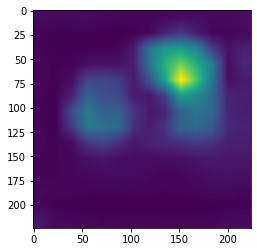

In [7]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_cam_model(np.reshape(rgb_img, (1, 224, 224, 3)))
    loss = predictions[:, img_index]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# no negative grads
grads = tf.keras.activations.relu(grads)  

# add grads of all channels
grad_weights = tf.reduce_mean(grads, axis=(0, 1))  

# block5_cov3.output * grad weights
cam = np.ones(output.shape[0:2], dtype=np.float32)
for i, w in enumerate(grad_weights):
    cam += w * output[:, :, i]
    
# resize, 0~1 normalization
cam = cv2.resize(cam.numpy(), (224, 224))
grad_cam = (cam - cam.min()) / (cam.max() - cam.min())

# plot
plt.imshow(grad_cam)

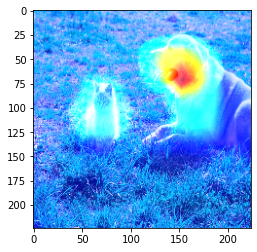

In [8]:
cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.add(cam, img))

# the model focuses on Labrador_retriever's ear.

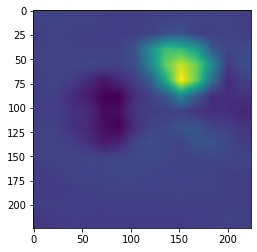

In [9]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_cam_model(np.reshape(rgb_img, (1, 224, 224, 3)))
    loss = predictions[:, img_index]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# # no negative grads
# grads = tf.keras.activations.relu(grads)  

# add grads of all channels
grad_weights = tf.reduce_mean(grads, axis=(0, 1))  

# block5_cov3.output * grad weights
cam = np.ones(output.shape[0:2], dtype=np.float32)
for i, w in enumerate(grad_weights):
    cam += w * output[:, :, i]
    
# resize, 0~1 normalization
cam = cv2.resize(cam.numpy(), (224, 224))
grad_cam = (cam - cam.min()) / (cam.max() - cam.min())

# plot
plt.imshow(grad_cam)

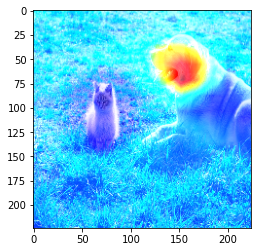

In [10]:
cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.add(cam, img))

# there is a negative weight on a cat, but the model has a very strong positive weight on the Labrador_retriever's ear, 
# so it classifies the image as Labrador_retriever.